<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «такси» собрала исторические данные о заказах такси в аэропортах. Для привлечения оптимального количества водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
Задача построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.




## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  make_scorer, mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

!pip install catboost
from catboost import CatBoostRegressor


Загрузим данные и выполним их ресемплирование по одному часу.

In [4]:
# загрузим данные
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.sort_index(inplace=True)

# объединим данные в пределах одних суток и посчитаем сумму потребления электроэнергии за сутки
data = data.resample('1H').sum()
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

In [5]:
print('Начало периода:', data.index.min())
print('Конец периода:', data.index.max())

Начало периода: 2018-03-01 00:00:00
Конец периода: 2018-08-31 23:00:00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


В данных представлено количество заказов такси с 1 марта 2018 года по 31 августа 2018 года - 6 месяцев.

Изучим тренды и сезонность

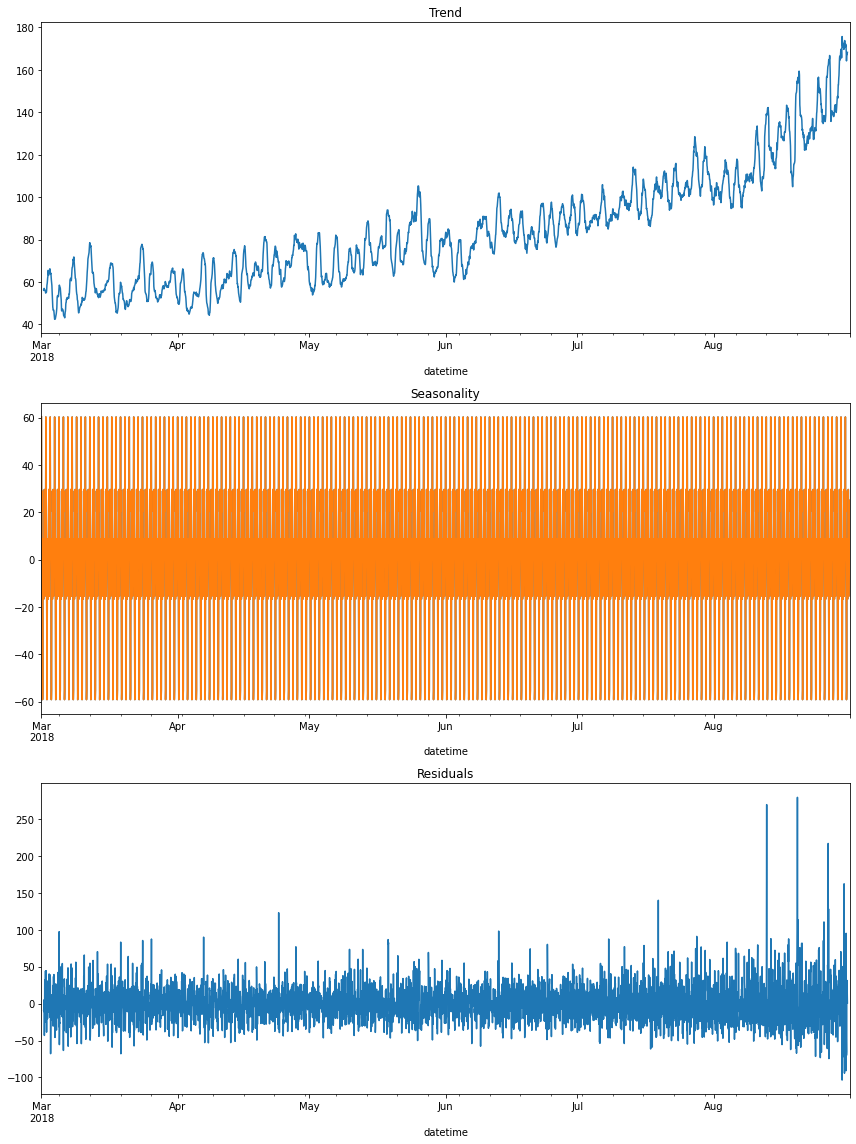

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()



По графикам мы видем определённый тренд и присутствие сезонности в наших данных.
Наш временной ряд не явлется стационарным, потому что у него меняется среднее значение.

Построим график временного ряда.

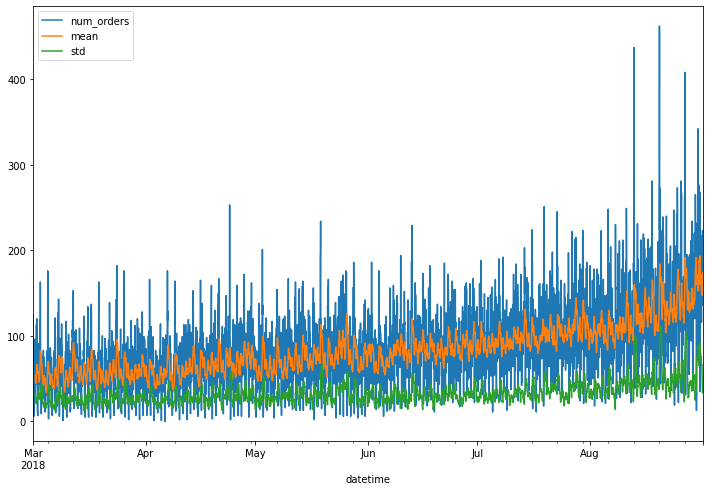

In [8]:
data_research = data.copy()
data_research['mean'] = data_research['num_orders'].rolling(15).mean()
data_research['std'] = data_research['num_orders'].rolling(15).std()

plt.figure(figsize=(12, 8))
data_research.plot(ax=plt.gca())

None

На графике видно, что количество заказов увеличивается.

Рассмотрим разности временного ряда: приведём данные к более стационарному виду, что бы их можно было прогнозировать.

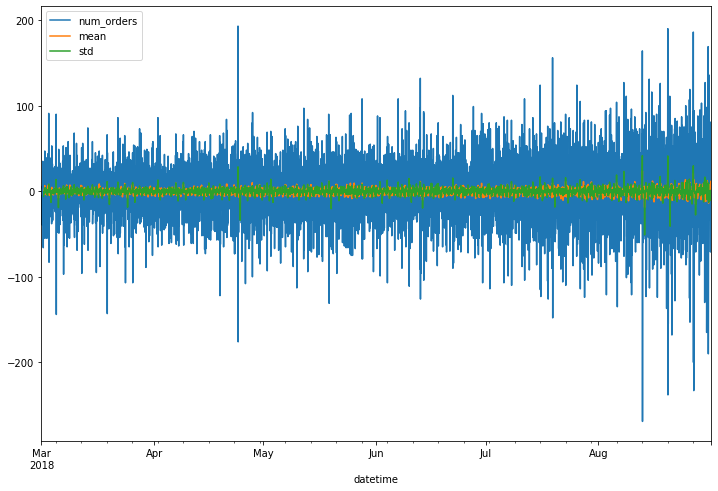

In [9]:
data_research =  data_research - data_research.shift()
plt.figure(figsize=(12, 8))
data_research.plot(ax=plt.gca())
None

Создадим признаки: календарные признаки (год, месяц, день, день недели), отстающие значения, скользящее среднее - этот признак задаёт общий тренд временного ряда. 
Календарные признаки по месяцам мы создавать не будем так как в данных мы имеем только пол года, соответственно тренды по месяцам учесть мы не можем. Календарный признак год - так же нам не понадобится, так как все данные за один и тот же год.

In [10]:
# функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [11]:
make_features(data, 30, 3)

In [12]:
data

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,154.0,207.000000
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,186.666667
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,165.666667


Разделем данные на тренировочную и тестовую выборки

In [13]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

## Обучение моделей

Обучим модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor. Рассчитаем метрику RMSE и выберем лучшую модель.

In [14]:
# Функция для рассчёта RMSE
def rmse_count(target, predict):
    return mean_squared_error(target, predict, squared=False)

In [15]:
# rmse для обучающей выборки
rmse_train = []

# параметры модели
model_params = []


In [16]:
# LinearRegression
model = LinearRegression()
model.fit(features_train, target_train)
predict_train = model.predict(features_train)
predict_test = model.predict(features_test)
rmse_LR_train = rmse_count(target_train, predict_train)
rmse_train.append(rmse_LR_train)
print ('Метрика RMSE для обучающей выборки', rmse_LR_train)
model_params.append(' ')


Метрика RMSE для обучающей выборки 25.578033488102715


Мы будем использовать  TimeSeriesSplit, чтобы предотвратить утечку данных

In [17]:
time_split = TimeSeriesSplit(n_splits=10)

In [18]:
# DecisionTreeRegressor

model_DT =  DecisionTreeRegressor(random_state=12345)
parametrs = {'max_depth': range(1,9,1), 'min_samples_leaf':range(1,8)}
model_Grid = GridSearchCV(model_DT, parametrs, cv=time_split, scoring = make_scorer(rmse_count, greater_is_better=False),
                          error_score = 'raise')

model_Grid.fit(features_train, target_train)

print(f'RMSE для лучшей модели DecisionTreeRegressor {-model_Grid.best_score_:.2f},\n\
Параметры лучшей модели {model_Grid.best_params_}')

rmse_DT = model_Grid.best_score_

rmse_train.append(abs(rmse_DT))
model_params.append(model_Grid.best_params_)

RMSE для лучшей модели DecisionTreeRegressor 28.75,
Параметры лучшей модели {'max_depth': 4, 'min_samples_leaf': 7}


In [19]:
# RandomForestRegressor

model_RF =  RandomForestRegressor(random_state=12345)
parametrs = {'n_estimators': range(1,10,1),
             'max_depth': range(1,9,1),
             'min_samples_leaf': range(1,8)
            }
model_Grid = GridSearchCV(model_RF, parametrs, cv=time_split, scoring = make_scorer(rmse_count, greater_is_better=False),
                          error_score = 'raise')

model_Grid.fit(features_train, target_train)
print(f'RMSE для лучшей модели RandomTreeRegressor {-model_Grid.best_score_:.2f},\n\
Лучшая модель RandomTreeRegressor с параметрами: {model_Grid.best_params_}')

rmse_RF = model_Grid.best_score_

rmse_train.append(abs(rmse_RF))
model_params.append(model_Grid.best_params_)

RMSE для лучшей модели RandomTreeRegressor 25.68,
Лучшая модель RandomTreeRegressor с параметрами: {'max_depth': 8, 'min_samples_leaf': 6, 'n_estimators': 9}


In [20]:
#CatBoostRegressor
model_CBR = CatBoostRegressor(random_state=12345)

parameters = {'depth'         : [1,10,2],
              'learning_rate' : [0.05, 0.1, 0.5],
              'iterations'    : [100, 200, 350, 500]
                 }
model_Grid = RandomizedSearchCV(
    model_CBR,
    parameters,
    scoring = make_scorer(rmse_count, greater_is_better=False),
    cv=time_split,
    n_jobs=-1)
model_Grid.fit(features_train, target_train, verbose=10)
print(f'RMSE для лучшей модели CatBoostRegressor: {-model_Grid.best_score_:.2f},\n\
Лучшая модель CatBoostRegressor с параметрами: {model_Grid.best_params_}')
rmse_CBR = model_Grid.best_score_

rmse_train.append(abs(rmse_CBR))
model_params.append(model_Grid.best_params_)

/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedd

/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedd

/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedd

/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedd

/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, feature_names, thread_count)
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1135: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedd

0:	learn: 24.7853023	total: 52.9ms	remaining: 5.24s
10:	learn: 19.0299806	total: 64.4ms	remaining: 521ms
20:	learn: 17.5579005	total: 78.5ms	remaining: 295ms
30:	learn: 16.5477489	total: 93.3ms	remaining: 208ms
40:	learn: 15.8543702	total: 108ms	remaining: 155ms
50:	learn: 15.2483285	total: 121ms	remaining: 117ms
60:	learn: 14.7087016	total: 136ms	remaining: 87.2ms
70:	learn: 14.1422752	total: 151ms	remaining: 61.7ms
80:	learn: 13.7604762	total: 167ms	remaining: 39.1ms
90:	learn: 13.4763818	total: 183ms	remaining: 18.1ms
99:	learn: 13.1242647	total: 197ms	remaining: 0us
0:	learn: 25.9591105	total: 1.18ms	remaining: 587ms
10:	learn: 17.6971912	total: 13.6ms	remaining: 603ms
20:	learn: 15.5125448	total: 26.9ms	remaining: 614ms
30:	learn: 13.4858537	total: 38.8ms	remaining: 586ms
40:	learn: 12.0860466	total: 49.7ms	remaining: 556ms
50:	learn: 10.9354433	total: 61.7ms	remaining: 543ms
60:	learn: 9.9169794	total: 75ms	remaining: 540ms
70:	learn: 9.3890382	total: 86.9ms	remaining: 525ms
80:	

0:	learn: 37.7947805	total: 88.4ms	remaining: 44.1s
10:	learn: 31.1517165	total: 460ms	remaining: 20.4s
20:	learn: 27.0739623	total: 821ms	remaining: 18.7s
30:	learn: 24.5351288	total: 1.2s	remaining: 18.2s
40:	learn: 22.8779028	total: 1.58s	remaining: 17.8s
50:	learn: 21.6297792	total: 2.02s	remaining: 17.8s
60:	learn: 20.7845376	total: 2.49s	remaining: 17.9s
70:	learn: 20.1164198	total: 2.98s	remaining: 18s
80:	learn: 19.5124627	total: 3.4s	remaining: 17.6s
90:	learn: 18.9594670	total: 3.99s	remaining: 18s
100:	learn: 18.5124476	total: 4.5s	remaining: 17.8s
110:	learn: 18.0222205	total: 5.18s	remaining: 18.2s
120:	learn: 17.6684218	total: 5.79s	remaining: 18.1s
130:	learn: 17.2444832	total: 6.21s	remaining: 17.5s
140:	learn: 16.8390605	total: 6.59s	remaining: 16.8s
150:	learn: 16.5971874	total: 7.02s	remaining: 16.2s
160:	learn: 16.2607926	total: 7.4s	remaining: 15.6s
170:	learn: 15.9142561	total: 7.78s	remaining: 15s
180:	learn: 15.4915930	total: 8.17s	remaining: 14.4s
190:	learn: 1

Сравним получившиеся результаты

In [21]:
list_of_models = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor','CatBoostRegressor']
result = pd.DataFrame({'Модель': list_of_models, 'параметры модели': model_params,
                       'rmse для тренировочной выборки': rmse_train})

In [22]:
result

,Модель,параметры модели,rmse для тренировочной выборки
0,LinearRegression,,25.578033
1,DecisionTreeRegressor,"{'max_depth': 4, 'min_samples_leaf': 7}",28.747518
2,RandomForestRegressor,"{'max_depth': 8, 'min_samples_leaf': 6, 'n_est...",25.680692
3,CatBoostRegressor,"{'learning_rate': 0.05, 'iterations': 500, 'de...",24.316867


0:	learn: 27.8576338	total: 55ms	remaining: 5.44s
10:	learn: 21.4113389	total: 72.5ms	remaining: 587ms
20:	learn: 20.1869154	total: 89.2ms	remaining: 336ms
30:	learn: 19.3930359	total: 106ms	remaining: 237ms
40:	learn: 18.8038213	total: 126ms	remaining: 181ms
50:	learn: 18.3361718	total: 150ms	remaining: 144ms
60:	learn: 17.8276881	total: 169ms	remaining: 108ms
70:	learn: 17.2932554	total: 188ms	remaining: 76.8ms
80:	learn: 17.0230208	total: 208ms	remaining: 48.8ms
90:	learn: 16.6092662	total: 233ms	remaining: 23.1ms
99:	learn: 16.3664747	total: 249ms	remaining: 0us
0:	learn: 26.6277495	total: 1.64ms	remaining: 820ms
10:	learn: 20.4942845	total: 19.9ms	remaining: 884ms
20:	learn: 19.3746965	total: 38.1ms	remaining: 868ms
30:	learn: 18.6411943	total: 53.3ms	remaining: 807ms
40:	learn: 17.9963640	total: 71.5ms	remaining: 800ms
50:	learn: 17.6247811	total: 93.4ms	remaining: 823ms
60:	learn: 17.0649765	total: 111ms	remaining: 802ms
70:	learn: 16.6169071	total: 130ms	remaining: 787ms
80:	le

0:	learn: 26.6277495	total: 54.3ms	remaining: 5.38s
10:	learn: 20.4942845	total: 70.2ms	remaining: 568ms
20:	learn: 19.3746965	total: 88.1ms	remaining: 331ms
30:	learn: 18.6411943	total: 104ms	remaining: 231ms
40:	learn: 17.9963640	total: 121ms	remaining: 174ms
50:	learn: 17.6247811	total: 138ms	remaining: 133ms
60:	learn: 17.0649765	total: 155ms	remaining: 99.4ms
70:	learn: 16.6169071	total: 172ms	remaining: 70.1ms
80:	learn: 16.1596704	total: 190ms	remaining: 44.6ms
90:	learn: 15.8600849	total: 210ms	remaining: 20.7ms
99:	learn: 15.6189007	total: 225ms	remaining: 0us
0:	learn: 24.7853023	total: 2.74ms	remaining: 1.37s
10:	learn: 19.0299806	total: 19.3ms	remaining: 856ms
20:	learn: 17.5579005	total: 35.9ms	remaining: 819ms
30:	learn: 16.5477489	total: 51.8ms	remaining: 784ms
40:	learn: 15.8543702	total: 67.9ms	remaining: 761ms
50:	learn: 15.2483285	total: 83.5ms	remaining: 735ms
60:	learn: 14.7087016	total: 103ms	remaining: 739ms
70:	learn: 14.1422752	total: 119ms	remaining: 720ms
80:

80:	learn: 22.5508713	total: 649ms	remaining: 953ms
90:	learn: 22.3619088	total: 778ms	remaining: 932ms
100:	learn: 22.1781125	total: 923ms	remaining: 905ms
110:	learn: 22.0229215	total: 949ms	remaining: 761ms
120:	learn: 21.8844033	total: 1.13s	remaining: 737ms
130:	learn: 21.7661771	total: 1.21s	remaining: 638ms
140:	learn: 21.6471082	total: 1.29s	remaining: 540ms
150:	learn: 21.5205573	total: 1.38s	remaining: 446ms
160:	learn: 21.4149528	total: 1.44s	remaining: 350ms
170:	learn: 21.3167975	total: 1.51s	remaining: 256ms
180:	learn: 21.1970114	total: 1.55s	remaining: 163ms
190:	learn: 21.0765177	total: 1.64s	remaining: 77.1ms
199:	learn: 20.9871167	total: 1.69s	remaining: 0us
0:	learn: 28.6022172	total: 125ms	remaining: 1m 2s
10:	learn: 20.2670600	total: 1.35s	remaining: 1m
20:	learn: 15.2943796	total: 2.71s	remaining: 1m 1s
30:	learn: 12.0406921	total: 4.02s	remaining: 1m
40:	learn: 9.9288191	total: 5.22s	remaining: 58.4s
50:	learn: 8.1707630	total: 6.41s	remaining: 56.4s
60:	learn: 

0:	learn: 28.9767926	total: 54.6ms	remaining: 5.41s
10:	learn: 22.6006551	total: 76.5ms	remaining: 619ms
20:	learn: 21.3829053	total: 96.5ms	remaining: 363ms
30:	learn: 20.5820936	total: 118ms	remaining: 263ms
40:	learn: 20.0360697	total: 138ms	remaining: 199ms
50:	learn: 19.5821675	total: 160ms	remaining: 153ms
60:	learn: 19.1967716	total: 179ms	remaining: 114ms
70:	learn: 18.8685732	total: 202ms	remaining: 82.5ms
80:	learn: 18.4923665	total: 223ms	remaining: 52.2ms
90:	learn: 18.1019179	total: 244ms	remaining: 24.2ms
99:	learn: 17.8070031	total: 264ms	remaining: 0us
0:	learn: 27.8576338	total: 2.67ms	remaining: 1.33s
10:	learn: 21.4113389	total: 25.9ms	remaining: 1.15s
20:	learn: 20.1869154	total: 44.3ms	remaining: 1.01s
30:	learn: 19.3930359	total: 63.3ms	remaining: 957ms
40:	learn: 18.8038213	total: 82.1ms	remaining: 919ms
50:	learn: 18.3361718	total: 103ms	remaining: 907ms
60:	learn: 17.8276881	total: 123ms	remaining: 885ms
70:	learn: 17.2932554	total: 143ms	remaining: 867ms
80:	l

0:	learn: 25.9591105	total: 52.7ms	remaining: 5.21s
10:	learn: 17.6971912	total: 62.8ms	remaining: 508ms
20:	learn: 15.5125448	total: 73.6ms	remaining: 277ms
30:	learn: 13.4858537	total: 85.1ms	remaining: 189ms
40:	learn: 12.0860466	total: 96.5ms	remaining: 139ms
50:	learn: 10.9354433	total: 109ms	remaining: 104ms
60:	learn: 9.9169794	total: 119ms	remaining: 76.4ms
70:	learn: 9.3890382	total: 130ms	remaining: 53.2ms
80:	learn: 8.7458192	total: 143ms	remaining: 33.5ms
90:	learn: 8.0921140	total: 155ms	remaining: 15.3ms
99:	learn: 7.6336668	total: 164ms	remaining: 0us
0:	learn: 29.6137383	total: 2.93ms	remaining: 290ms
10:	learn: 23.1982582	total: 25.9ms	remaining: 210ms
20:	learn: 22.1804063	total: 50.1ms	remaining: 189ms
30:	learn: 21.3993704	total: 73.7ms	remaining: 164ms
40:	learn: 20.7539797	total: 98ms	remaining: 141ms
50:	learn: 20.2211556	total: 119ms	remaining: 114ms
60:	learn: 19.7952491	total: 141ms	remaining: 89.9ms
70:	learn: 19.4996864	total: 163ms	remaining: 66.8ms
80:	lea

0:	learn: 26.1071408	total: 52.4ms	remaining: 5.19s
10:	learn: 19.9451633	total: 68.3ms	remaining: 553ms
20:	learn: 18.7544319	total: 83.9ms	remaining: 316ms
30:	learn: 18.1300304	total: 99.8ms	remaining: 222ms
40:	learn: 17.4594055	total: 115ms	remaining: 166ms
50:	learn: 16.7993476	total: 131ms	remaining: 126ms
60:	learn: 16.1842099	total: 148ms	remaining: 94.9ms
70:	learn: 15.6181210	total: 163ms	remaining: 66.6ms
80:	learn: 15.2035896	total: 180ms	remaining: 42.2ms
90:	learn: 14.8331530	total: 196ms	remaining: 19.4ms
99:	learn: 14.5559520	total: 211ms	remaining: 0us
0:	learn: 25.8924687	total: 1.34ms	remaining: 671ms
10:	learn: 18.3404443	total: 17.8ms	remaining: 791ms
20:	learn: 16.7645991	total: 32.3ms	remaining: 736ms
30:	learn: 15.6297510	total: 45ms	remaining: 681ms
40:	learn: 14.5135009	total: 60.1ms	remaining: 673ms
50:	learn: 13.8148860	total: 73.2ms	remaining: 645ms
60:	learn: 12.9634765	total: 88.4ms	remaining: 636ms
70:	learn: 12.4412747	total: 103ms	remaining: 620ms
80:

0:	learn: 28.7940586	total: 56.6ms	remaining: 5.61s
10:	learn: 22.2204846	total: 76.2ms	remaining: 616ms
20:	learn: 21.0744357	total: 93ms	remaining: 350ms
30:	learn: 20.1073580	total: 113ms	remaining: 252ms
40:	learn: 19.4779248	total: 133ms	remaining: 191ms
50:	learn: 19.0173582	total: 151ms	remaining: 145ms
60:	learn: 18.6213936	total: 171ms	remaining: 109ms
70:	learn: 18.1750636	total: 191ms	remaining: 77.9ms
80:	learn: 17.8986005	total: 210ms	remaining: 49.3ms
90:	learn: 17.5268018	total: 232ms	remaining: 23ms
99:	learn: 17.2006494	total: 248ms	remaining: 0us
0:	learn: 26.1071408	total: 1.68ms	remaining: 836ms
10:	learn: 19.9451633	total: 17.6ms	remaining: 782ms
20:	learn: 18.7544319	total: 34.8ms	remaining: 793ms
30:	learn: 18.1300304	total: 51.8ms	remaining: 784ms
40:	learn: 17.4594055	total: 71.2ms	remaining: 797ms
50:	learn: 16.7993476	total: 85.5ms	remaining: 752ms
60:	learn: 16.1842099	total: 103ms	remaining: 740ms
70:	learn: 15.6181210	total: 119ms	remaining: 718ms
80:	lear

0:	learn: 25.8924687	total: 53.9ms	remaining: 5.33s
10:	learn: 18.3404443	total: 68.3ms	remaining: 553ms
20:	learn: 16.7645991	total: 82ms	remaining: 308ms
30:	learn: 15.6297510	total: 94.8ms	remaining: 211ms
40:	learn: 14.5135009	total: 108ms	remaining: 155ms
50:	learn: 13.8148860	total: 121ms	remaining: 116ms
60:	learn: 12.9634765	total: 134ms	remaining: 85.5ms
70:	learn: 12.4412747	total: 147ms	remaining: 60.2ms
80:	learn: 11.8183384	total: 163ms	remaining: 38.3ms
90:	learn: 11.4991247	total: 180ms	remaining: 17.8ms
99:	learn: 11.0532144	total: 192ms	remaining: 0us
0:	learn: 30.9263754	total: 2.72ms	remaining: 269ms
10:	learn: 24.4402247	total: 30.4ms	remaining: 246ms
20:	learn: 23.2919573	total: 53.5ms	remaining: 201ms
30:	learn: 22.4542273	total: 80.4ms	remaining: 179ms
40:	learn: 21.9274688	total: 102ms	remaining: 147ms
50:	learn: 21.3020628	total: 125ms	remaining: 120ms
60:	learn: 20.9295185	total: 149ms	remaining: 94.9ms
70:	learn: 20.5433632	total: 172ms	remaining: 70.2ms
80:	

Таким образом, мы видем, что модель CatBoostRegressor с параметрами 'learning_rate= 0.05, iterations= 500, depth= 10, random_state=12345 имеет наилучшую метрику RMSE= 24.31. Выбирем эту модель для проверки на тестовой выборке.

## Тестирование

In [23]:
# CatBoostRegressor

model_CBR =  CatBoostRegressor(learning_rate= 0.05, iterations= 500, depth= 10, random_state=12345)
model_CBR.fit(features_train, target_train)
predict_test = model_CBR.predict(features_test)
rmse_test_CBR = rmse_count(target_test, predict_test)

0:	learn: 37.7947805	total: 38.4ms	remaining: 19.1s
1:	learn: 36.9635188	total: 74.6ms	remaining: 18.6s
2:	learn: 36.2180292	total: 107ms	remaining: 17.7s
3:	learn: 35.4533516	total: 141ms	remaining: 17.5s
4:	learn: 34.7183339	total: 175ms	remaining: 17.3s
5:	learn: 34.0493812	total: 209ms	remaining: 17.2s
6:	learn: 33.4250522	total: 244ms	remaining: 17.2s
7:	learn: 32.8314624	total: 283ms	remaining: 17.4s
8:	learn: 32.2226728	total: 318ms	remaining: 17.3s
9:	learn: 31.6496221	total: 350ms	remaining: 17.2s
10:	learn: 31.1517165	total: 385ms	remaining: 17.1s
11:	learn: 30.6646503	total: 419ms	remaining: 17.1s
12:	learn: 30.2220954	total: 453ms	remaining: 17s
13:	learn: 29.7968459	total: 492ms	remaining: 17.1s
14:	learn: 29.3454709	total: 526ms	remaining: 17s
15:	learn: 28.9112421	total: 560ms	remaining: 16.9s
16:	learn: 28.4957655	total: 595ms	remaining: 16.9s
17:	learn: 28.1104481	total: 627ms	remaining: 16.8s
18:	learn: 27.7817851	total: 664ms	remaining: 16.8s
19:	learn: 27.4135774	to

163:	learn: 16.1275749	total: 5.95s	remaining: 12.2s
164:	learn: 16.1026907	total: 5.98s	remaining: 12.1s
165:	learn: 16.0517535	total: 6.01s	remaining: 12.1s
166:	learn: 16.0364909	total: 6.04s	remaining: 12s
167:	learn: 16.0004587	total: 6.08s	remaining: 12s
168:	learn: 15.9918438	total: 6.11s	remaining: 12s
169:	learn: 15.9371094	total: 6.14s	remaining: 11.9s
170:	learn: 15.9142561	total: 6.18s	remaining: 11.9s
171:	learn: 15.8726900	total: 6.21s	remaining: 11.8s
172:	learn: 15.8313023	total: 6.24s	remaining: 11.8s
173:	learn: 15.7932464	total: 6.27s	remaining: 11.8s
174:	learn: 15.7599153	total: 6.3s	remaining: 11.7s
175:	learn: 15.7212360	total: 6.33s	remaining: 11.7s
176:	learn: 15.6865365	total: 6.37s	remaining: 11.6s
177:	learn: 15.6458997	total: 6.4s	remaining: 11.6s
178:	learn: 15.5898321	total: 6.43s	remaining: 11.5s
179:	learn: 15.5503361	total: 6.46s	remaining: 11.5s
180:	learn: 15.4915930	total: 6.49s	remaining: 11.4s
181:	learn: 15.4881490	total: 6.52s	remaining: 11.4s
1

322:	learn: 10.7809565	total: 11.1s	remaining: 6.06s
323:	learn: 10.7557725	total: 11.1s	remaining: 6.03s
324:	learn: 10.7171362	total: 11.1s	remaining: 6s
325:	learn: 10.6863381	total: 11.2s	remaining: 5.96s
326:	learn: 10.6618490	total: 11.2s	remaining: 5.92s
327:	learn: 10.6314834	total: 11.2s	remaining: 5.89s
328:	learn: 10.6009813	total: 11.3s	remaining: 5.86s
329:	learn: 10.5761711	total: 11.3s	remaining: 5.82s
330:	learn: 10.5594402	total: 11.3s	remaining: 5.79s
331:	learn: 10.5415424	total: 11.4s	remaining: 5.75s
332:	learn: 10.4960129	total: 11.4s	remaining: 5.72s
333:	learn: 10.4766999	total: 11.4s	remaining: 5.68s
334:	learn: 10.4587908	total: 11.5s	remaining: 5.65s
335:	learn: 10.4268611	total: 11.5s	remaining: 5.62s
336:	learn: 10.4096987	total: 11.5s	remaining: 5.58s
337:	learn: 10.3771225	total: 11.6s	remaining: 5.54s
338:	learn: 10.3524221	total: 11.6s	remaining: 5.51s
339:	learn: 10.3287383	total: 11.6s	remaining: 5.47s
340:	learn: 10.3018654	total: 11.7s	remaining: 5.

481:	learn: 7.4270112	total: 16.4s	remaining: 612ms
482:	learn: 7.4141690	total: 16.4s	remaining: 578ms
483:	learn: 7.3959057	total: 16.5s	remaining: 544ms
484:	learn: 7.3814672	total: 16.5s	remaining: 510ms
485:	learn: 7.3661942	total: 16.5s	remaining: 476ms
486:	learn: 7.3656476	total: 16.6s	remaining: 442ms
487:	learn: 7.3566901	total: 16.6s	remaining: 408ms
488:	learn: 7.3298441	total: 16.6s	remaining: 374ms
489:	learn: 7.3092790	total: 16.7s	remaining: 340ms
490:	learn: 7.2930887	total: 16.7s	remaining: 306ms
491:	learn: 7.2713029	total: 16.7s	remaining: 272ms
492:	learn: 7.2599648	total: 16.8s	remaining: 238ms
493:	learn: 7.2319742	total: 16.8s	remaining: 204ms
494:	learn: 7.2020426	total: 16.8s	remaining: 170ms
495:	learn: 7.1869901	total: 16.9s	remaining: 136ms
496:	learn: 7.1704763	total: 16.9s	remaining: 102ms
497:	learn: 7.1493953	total: 17s	remaining: 68.1ms
498:	learn: 7.1278432	total: 17s	remaining: 34.1ms
499:	learn: 7.1096764	total: 17s	remaining: 0us


In [24]:
print('RMSE для тестовой выборки',  rmse_test_CBR)

RMSE для тестовой выборки 46.11684958274473


Это удовлетворяет нашим требованиям - меньше 48.

## Вывод:
Компания такси собрала исторические данные о заказах такси в аэропортах. Для привлечения большего количества водителей в период пиковой нагрузки, нам нужно было спрогнозировать количество заказов такси на следующий час. 
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Для этого:

 1. Загрузили данные и выполним их ресемплирование по одному часу.
 2. Провели анализ данных: выявили наличие тренда и сезонности. По графикам определили наличие тренда и присутствие сезонности в наших данных. Временной ряд не был стационарным. Что бы данные  можно было прогнозировать прили временной ряд к стационарному виду используя разности временного ряда.

 3. Создали признаки: календарные признаки (день, день недели), отстающие значения, скользящее среднее - этот признак задаёт общий тренд временного ряда. Календарные признаки по месяцам мы не создавалиь так как в данных мы имеем только пол года, соответственно тренды по месяцам учесть мы не можем. Календарный признак год - так же нам не понадобился, так как все данные за один и тот же год.
 4. Разбили данные на тренировочную и тестовую выборки в соотношении 9:1
 5. Обучили модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor. Нашили их наилучшие парамеры для наилучшей метрики RMSE.
 6. Выбрали наилучшую маодель: ей оказалась модель CatBoostRegressor с параметрами 'learning_rate= 0.05, iterations= 500, depth= 10, random_state=12345.
 7. Проверили работу модели на тестовой выборке. Получили значение метрики RMSE=46.11, что удовлетворяет нашим требованиям - меньше 48.
 
 
Таким образом, была построена модель для предсказания количества заказов такси на следующий час. Она поможет компании оптимизировать количество водителей в аэропорту и тем самым увеличить прибль.